# Find Label Errors in Semantic Segmentation Datasets

This 5-minute quickstart tutorial shows how you can use cleanlab to find potential label errors in image datasets for semantic segmentation. In semantic segmentation for supervised learning settings, our data consists of a series of images and a corresponding mask that labels each pixel in the image as one of K classes. Models are trained on this labeled mask to predict the class of each pixel in an image. The labeled mask, however, might contain errors. 

Semantic segmentation informs powerful systems such as self-driving cars and medical imaging, so therefore it is important to maintain high quality labels. With cleanlab, you can identify the mislabeled images and either correct or remove them. After correcting these issues, **you can train an even better model with no change to any model or training code!**

In order to to test our error finding methods we utilize the [SYNTHIA](https://synthia-dataset.net) dataset, a synthetic semantic segmentations dataset in which we introduce errors.

The complete dataset and analysis of the underlying algorithms can be found in our paper 
<!-- here [FIXME](FIXME) -->

**Overview of what we'll do in this tutorial:** 
 
- Rank images based on their overall label quality using `cleanlab.semantic_segmentation.rank.get_label_quality_scores`.
- Use 2 methods to determine score and see how they perform
- Perform a more in-depth analysis using 
`cleanlab.semantic_segmentation.filter.find_label_issues`.
- Visualize our errors using 
`cleanlab.semantic_segmentation.summary.display_issues`.
and 
`cleanlab.semantic_segmentation.summary.common_label_issues`.

<div class="alert alert-info">
Quickstart
<br/>
    
cleanlab uses two inputs to handle semantic segmentation data classification data:
- `labels`: Array of dimension (N,H,W) where N is the number of images, K is the number of classes, and H and W are dimension of the image. We assume an integer encoded image. For one-hot encoding one can `np.argmax(labels_one_hot,axis=1)` assuming that `labels_one_hot` is of dimension (N,K,H,W)
- `pred_probs`: Array of dimension (N,K,H,W), similar to `labels` where `K` is the number of classes.

Using these, you can find/display label issues with this code: 

<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```python

from cleanlab.semantic_segmentation.filter import find_label_issues 
from cleanlab.semantic_segmentation.summary import display_issues
    
issues = find_label_issues(labels, pred_probs)
display_issues(issues, pred_probs=pred_probs, labels=labels,
               top=10)

```
    
</div>
</div>

## 1. Install required dependencies and download data

You can use `pip` to install all packages required for this tutorial as follows: 

    !pip install cleanlab 

In [1]:
%%capture
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/ImageSegmentation/given_masks.npy' 

In [2]:
%%capture
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/ImageSegmentation/predicted_masks.npy' 

In [3]:
# Package installation (hidden on docs website).

dependencies = ["cleanlab"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab  # for colab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

In [4]:
import numpy as np
from cleanlab.segmentation.filter import find_label_issues 
from cleanlab.segmentation.rank import get_label_quality_scores, issues_from_scores 
from cleanlab.segmentation.summary import display_issues, common_label_issues, filter_by_class 

## 2. Get data, labels, and pred_probs

We begin by loading the `labels` and `pred_probs` for our dataset, which are the only inputs required to find label issues and obtain the label quality score for each image with cleanlab. Here we use `pred_probs` which are from the SYNTHIA dataset. Our example [training notebook](https://github.com/cleanlab/examples/blob/master/segmentation/training_ResNeXt50_for_Semantic_Segmentation_on_SYNTHIA.ipynb) contains the code to produce such `pred_probs` and save them in a `.npy` file, which we simply load here via a `np.load` function.

Here's what an example image looks like in the SYNTHIA dataset. For every image there is also `label` mask provided in which each pixel is integer-encoded as one of the SYNTHIA classes: sky, building, road, sidewalk, fence, vegetation, pole, car, traffic sign, person, bicycle, motorcycle, traffic light, terrain, rider, truck, bus, train, wall, and unlabeled. 

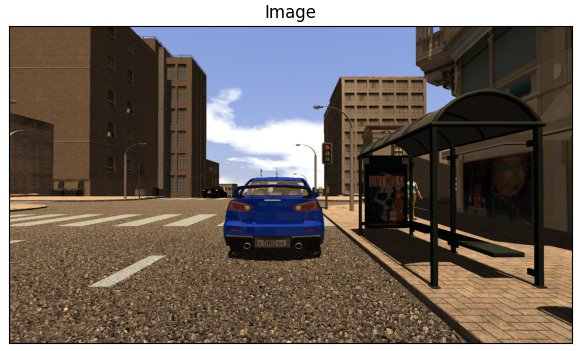

In semantic segmentation tasks `labels` and `pred_probs` are formatted with the following dimensions:

    N - Number of images in the dataset
    K - Number of classes in the dataset
    H - Height of each image
    W - Width of each image

Each pixel in the dataset is labeled with one of *K* possible classes. The `pred_probs` contain a length-*K* vector for **each** pixel in the dataset (which sums to 1 for each pixel). This results in an array of size `(N,K,H,W)`. 

Note that Cleanlab requires **only** the `pred_probs` and the `labels` in order to discover label errors.


**pred_probs**
dim: (N,K,H,W)

In [5]:
pred_probs_filepaths ='predicted_masks.npy'
pred_probs = np.load(pred_probs_filepaths, mmap_mode='r+')
pred_probs.shape

(139, 20, 1088, 1920)

The `labels` contain a pixel label, where each pixel must be integer in `0, 1, ..., K-1`. This results in an array of size `(N,H,W)`. 

**labels**
dim: (N,H,W)

In [6]:
label_filepaths ='given_masks.npy'
labels = np.load(label_filepaths, mmap_mode='r+')
labels.shape

(139, 1088, 1920)

Note that these correspond to the labeled mask from the dataset, and the extracted probabilities of a trained classifier. If using your own dataset, which may consider iterating on memmaped numpy arrays.

- `labels`: Array of dimension (N,H,W) where N is the number of images, K is the number of classes, and H and W are dimension of the image. We assume an integer encoded image. For one-hot encoding one can `np.argmax(labels_one_hot,axis=1)` assuming that `labels_one_hot` is of dimension (N,K,H,W)
- `pred_probs`: Array of dimension (N,K,H,W), similar to `labels` where `K` is the number of classes.

**class_names**
dim: (K,)

Many of our functions optionally use the class names to improve visualization. We can see that we have the same classes here as the famous Cityscapes dataset. 

In [7]:
SYNTHIA_CLASSES = ['unlabeled','sky', 'building', 'road', 'sidewalk', 'fence', 'vegetation','pole','car', \
               'traffic sign','person','bicycle','motorcycle','traffic light', 'terrain', \
               'rider',  'truck', 'bus', 'train','wall']

## 3. Use cleanlab to find label issues 

In segmentation, we consider an image mislabeled if the given mask does not match what truly appears in the image that is being segmented. More specifically, when a pixel is labeled as class `i` but the pixel _really_ belongs to class `j`. This generally happens when an image is annotated maunally by human annotators.

Below are examples of three types of annotation errors which are common in segmentation datasets, here taken from a version of the SYNTHIA dataset

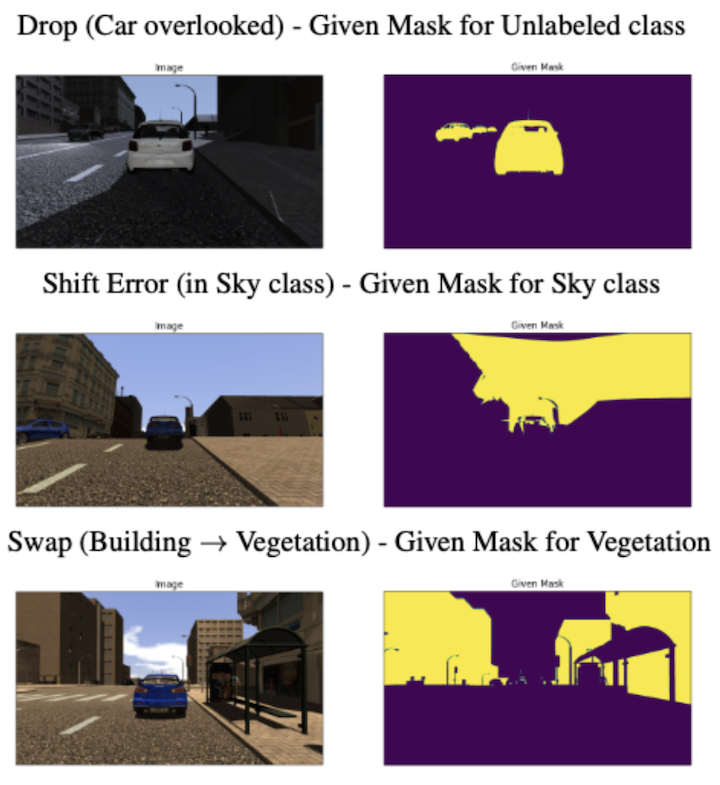


Based on the given `labels` and out-of-sample `pred_probs`, cleanlab can quickly help us identify label issues in our dataset by calling `find_label_issues()`. 

Here we sort the indices of the identified label issues by cleanlab’s self-confidence score, which measures the quality of each given label via the probability assigned to it in our model’s prediction. The returned `issues` is a boolean mask of dimension `(N,H,W)`, where `True` corresponds to a detected error sorted by image quality with the lowest quality images coming first. 

In [8]:
issues = find_label_issues(labels, pred_probs,downsample = 16, n_jobs=None, batch_size=100000)

number of examples processed for estimating thresholds:   0%|          | 0/1134240 [00:00<?, ?it/s]

number of examples processed for checking labels:   0%|          | 0/1134240 [00:00<?, ?it/s]

Total number of examples whose labels have been evaluated: 1134240


**Note:**
 - The ``downsample`` flag gives us performance benefits for large datasets, but for maximum accuracy we can keep the value lower.
 - To maximize efficiency, try to use the largest `batch_size` your memory allows.

### Visualize top label issues

Let's look at the top 2 issues that cleanlab thinks are most likely mislabeled. This functions visualizes issues found by `find_label_issues`. Namely images located at index 131 and 29 have large errors in the top half. The image labeled in red is where cleanlab believes the given mask does not match what really appears in the image.

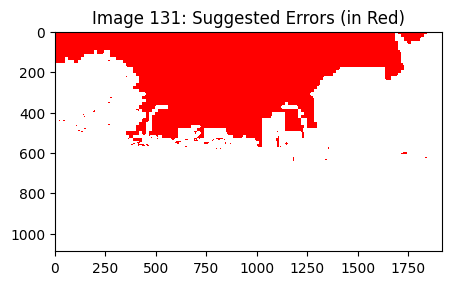

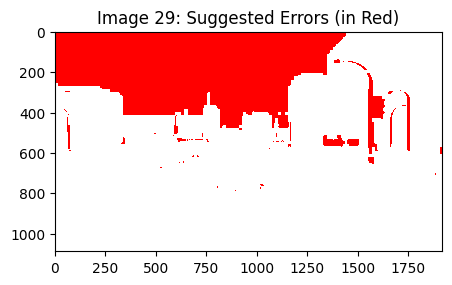

In [9]:
display_issues(issues,top=2)

To ensure that this is not a false positive in error, we can input more information into the function such as the `pred_probs`, `labels`, and `class_names` to determine if we have really found an error.

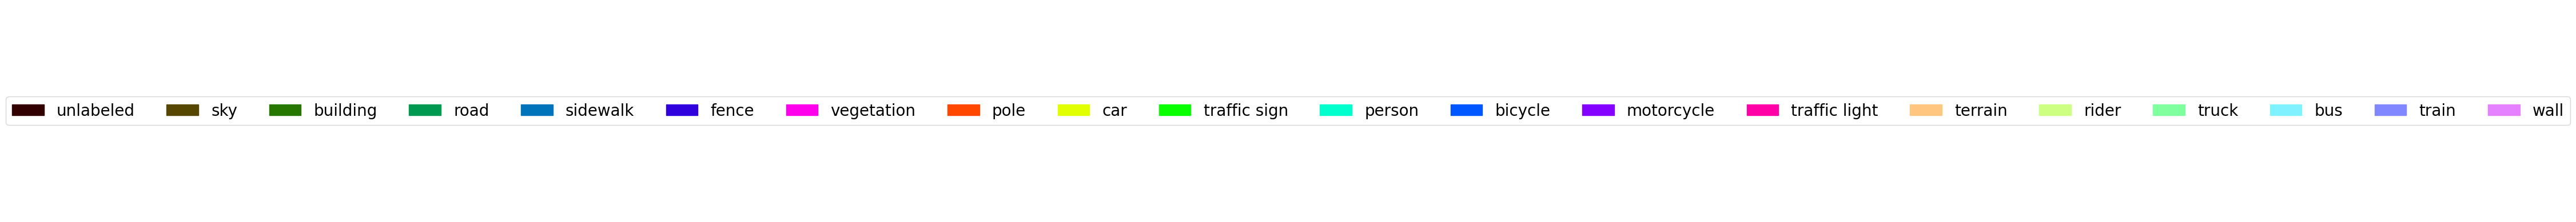

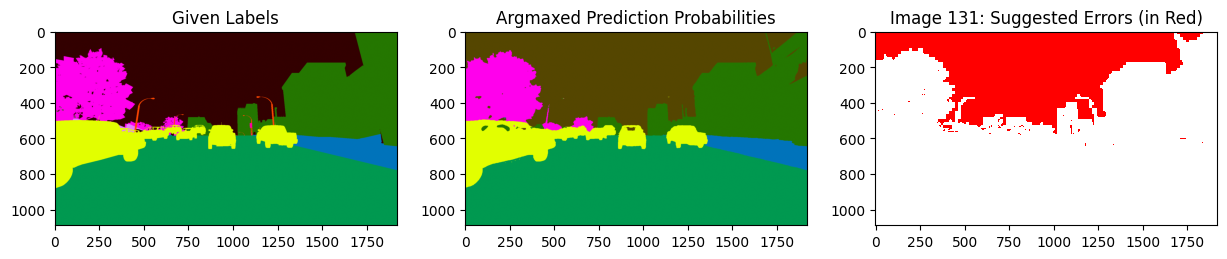

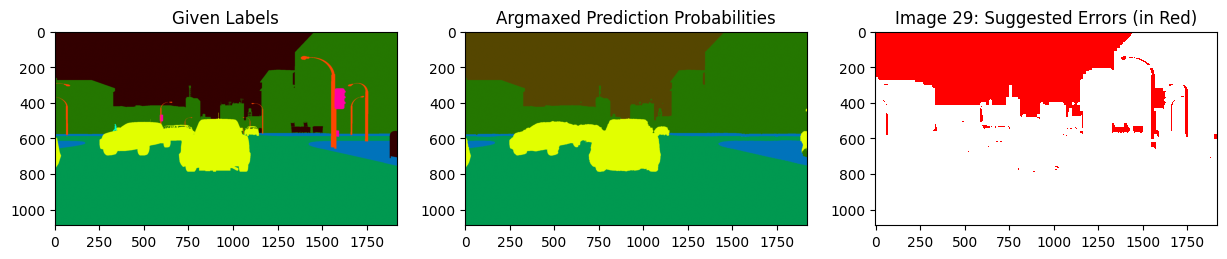

In [10]:
display_issues(issues, labels=labels, pred_probs=pred_probs,class_names=SYNTHIA_CLASSES,top=2)

After adding the `pred_probs`, `labels`, and `class_names` we see more information error to determine if this is really an issue:
 - `labels` and `pred_probs` generates the first two columns. This segments the image based on the class that appears on the given label and what the model predicted at that pixel.
 - `class_names` - this allows us to create a legend which color codes our segmentation.


In the leftmost image we can see that the dark brown area, which is the `unlabeled` class as shown in the legend, was the given label. The middle image then shows the model believes that this area is infact the `sky`, a light brown shade in the legend. The rightmost column highlights the discrepancy between the classes in red to show which area was marked an error.

The part of the sky that was mislabeled is clearly seen when comparing the plots in the output.

### Most common class-level image mislabels 

We may also wish to understand which classes tend to be most commonly mislabeled throughout the entire dataset by calling `common_label_issues()`. 

In [11]:
common_label_issues(issues,labels=labels, pred_probs=pred_probs, class_names=SYNTHIA_CLASSES)

100%|██████████| 10616151/10616151 [01:02<00:00, 170143.56it/s]

Class 'unlabeled' is potentially mislabeled as class for 'sky' 3764912 pixels in the dataset
Class 'unlabeled' is potentially mislabeled as class for 'car' 1691561 pixels in the dataset
Class 'pole' is potentially mislabeled as class for 'building' 1567818 pixels in the dataset
Class 'unlabeled' is potentially mislabeled as class for 'building' 1224682 pixels in the dataset
Class 'wall' is potentially mislabeled as class for 'building' 315644 pixels in the dataset
Class 'person' is potentially mislabeled as class for 'building' 293412 pixels in the dataset
Class 'unlabeled' is potentially mislabeled as class for 'sidewalk' 263385 pixels in the dataset
Class 'pole' is potentially mislabeled as class for 'sidewalk' 230966 pixels in the dataset
Class 'traffic light' is potentially mislabeled as class for 'building' 215248 pixels in the dataset
Class 'wall' is potentially mislabeled as class for 'sidewalk' 191852 pixels in the dataset
Class 'building' is potentially mislabeled as class for

,given_label,predicted_label,num_pixel_issues
0,unlabeled,sky,3764912
1,unlabeled,car,1691561
2,pole,building,1567818
3,unlabeled,building,1224682
4,wall,building,315644
5,person,building,293412
6,unlabeled,sidewalk,263385
7,pole,sidewalk,230966
8,traffic light,building,215248
9,wall,sidewalk,191852


The printed information above is also stored in pd.DataFrame 

### Find errors in images by focusing on just one class

With cleanlab, we can also just focus on issues of a specific class we might want to investigate further. Lets say we just want to focus on any issues related to the class `car`. We can do so using `filter_by_class` therefore in the third column we can see only car label errors showing up. 

We are no longer encountering the `sky` errors we saw in the previous section, and focus on just one class.

By the color-coding, we can see that the `car` class has been dropped to the `unlabeled` class, and is a true positive for error detection!

In [12]:
class_issues = filter_by_class(SYNTHIA_CLASSES.index("car"), issues,labels=labels, pred_probs=pred_probs)

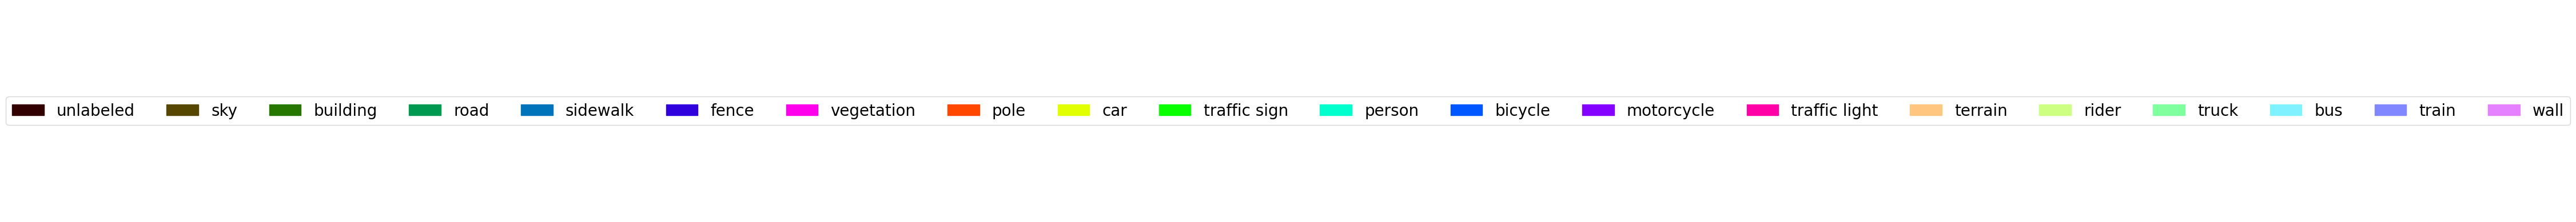

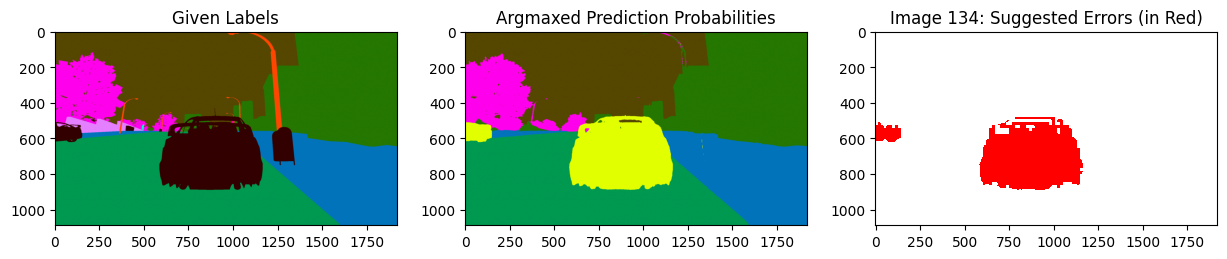

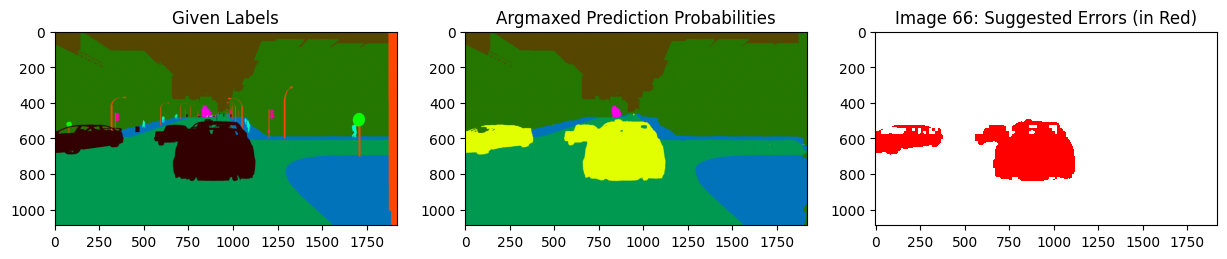

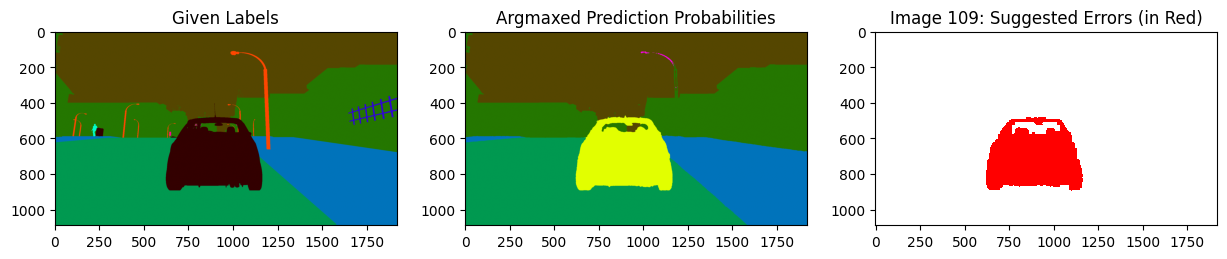

In [13]:
display_issues(class_issues, pred_probs=pred_probs, labels=labels, top=3, class_names=SYNTHIA_CLASSES)

###  Get label quality scores

Cleanlab can provide an overall label quality score for each image (ranging from 0 to 1 such that lower scores indicate images more likely to contain some mislabeled class) to estimate how confident we are whether an image is correctly labeled or not. We can also obtain label quality scores for each individual image and manually decide which of these are label issues by thresholding them.

**Note:** For automatically estimating which pixels are mislabeled (and the number of label errors), you should use `find_label_issues()` instead. 

Looking at label quality scores is most useful if you only have time to review a few images and want to prioritize which ones to look at, or if you're specifically aiming to detect label errors with high precision (or high recall) rather than overall estimation of the set of mislabeled tokens. 

The default method for calculating these label quality scores per image is using a ``softmin``.

In [14]:
image_scores_softmin, pixel_scores = get_label_quality_scores(labels, pred_probs, method="softmin")

images processed using softmin:   0%|          | 0/139 [00:00<?, ?it/s]

A secondary method, which uses the same principles as confident learning from ``find_label_issues`` can also be used to determine a score. 

``find_label_issues`` is computationally slower but automatically determines the correct threshold to determine error labels. 

In [15]:
image_scores_num_issues, pixel_scores = get_label_quality_scores(labels, pred_probs,  method="num_pixel_issues", downsample = 16, n_jobs=None, batch_size=100000)

number of examples processed for estimating thresholds:   0%|          | 0/1134240 [00:00<?, ?it/s]

number of examples processed for checking labels:   0%|          | 0/1134240 [00:00<?, ?it/s]

Total number of examples whose labels have been evaluated: 1134240


Both methods above return the ``pixel_scores``, which is a 0 to 1 score for each pixel. We can use the following function to extract the same style `True` or `False` mask as `find_label_issues()`.

In [19]:
issues_from_score = issues_from_scores(image_scores_softmin, pixel_scores, threshold=0.5) 

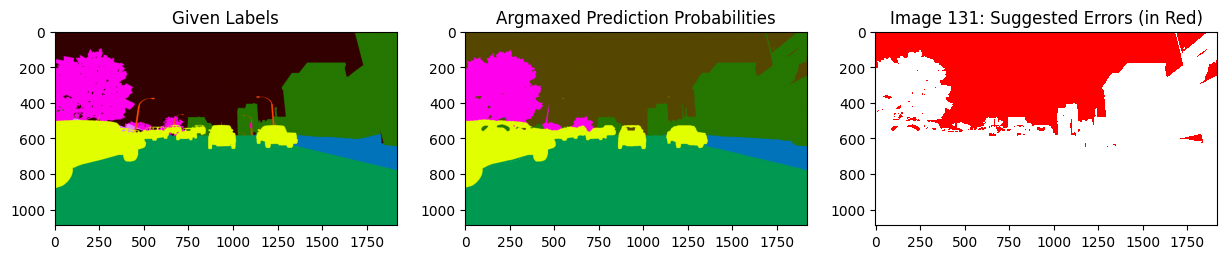

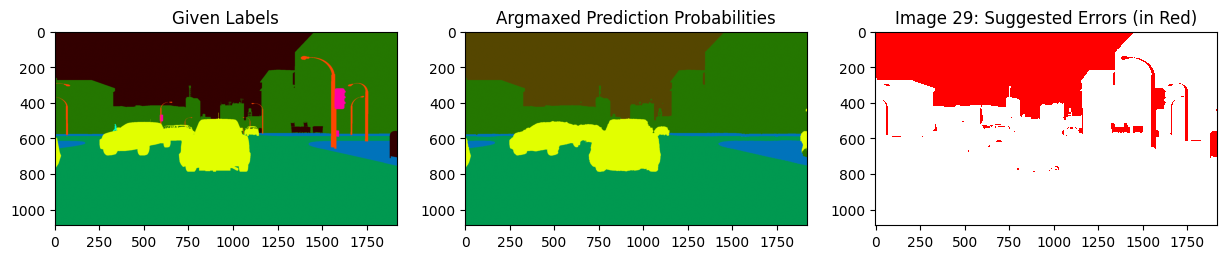

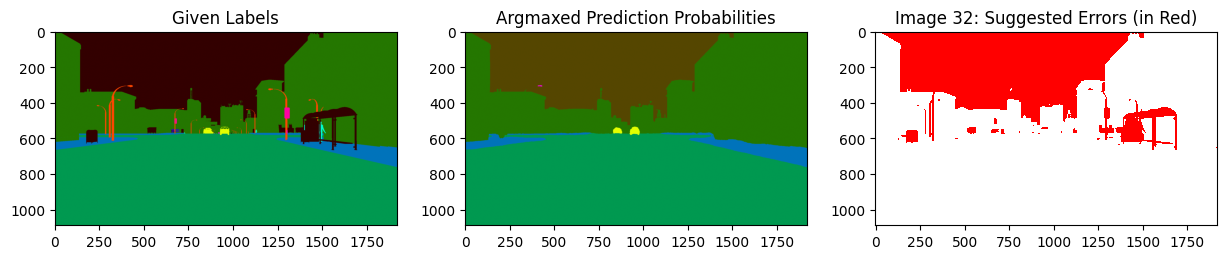

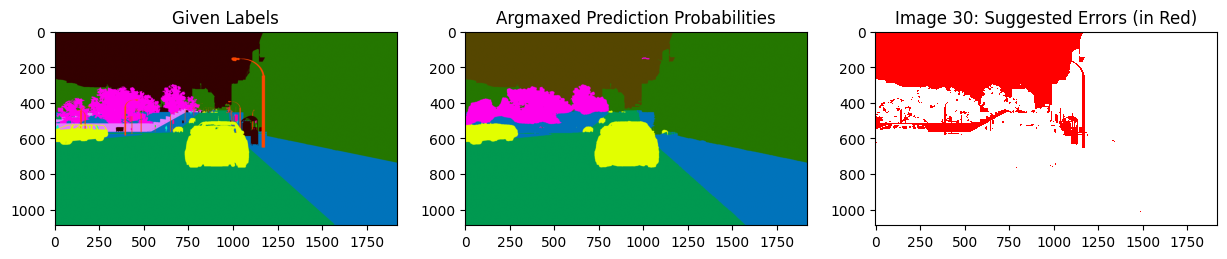

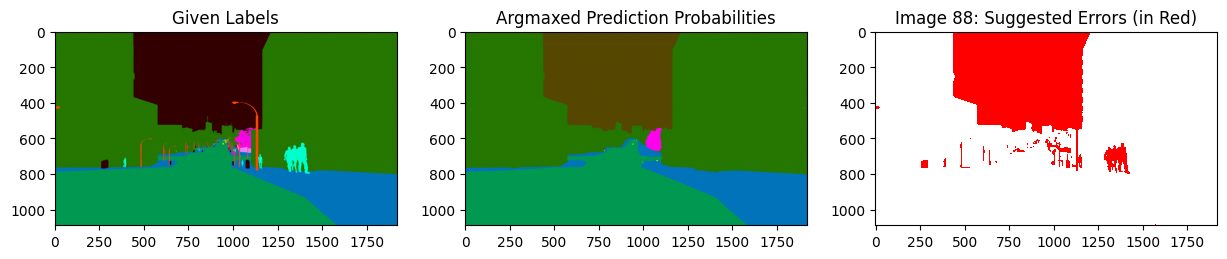

In [20]:
display_issues(issues_from_score, pred_probs=pred_probs, labels=labels, top=5) 

We can see that the errors are dominated by label errors in the sky!

In [23]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.
highlighted_indices = [ 78,  16, 120,  34, 137,  51,  71,   8, 106,  94]

if not all(np.argsort(issues_from_score.sum((1,2)))[:10]==highlighted_indices):
    raise Exception("Some highlighted examples are missing from ranked_label_issues.")